# Plot timelines

/tmp/ipykernel_1760239/1208620907.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_scans_sets = filtered_df.groupby('Description').apply(find_missing_scans)
/tmp/ipykernel_1760239/1208620907.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby('Description').apply(append_missing_scans).reset_index(drop=True)


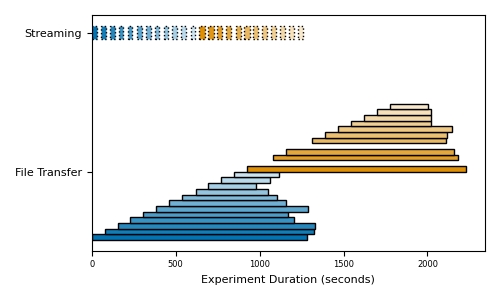

/tmp/ipykernel_1760239/1208620907.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_scans_sets = filtered_df.groupby('Description').apply(find_missing_scans)
/tmp/ipykernel_1760239/1208620907.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby('Description').apply(append_missing_scans).reset_index(drop=True)


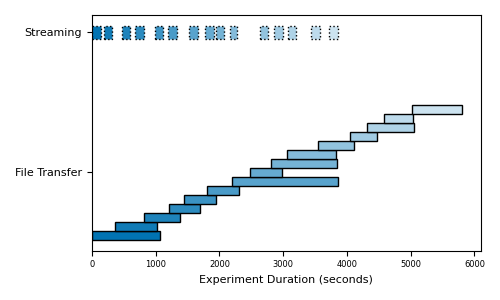

/tmp/ipykernel_1760239/1208620907.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_scans_sets = filtered_df.groupby('Description').apply(find_missing_scans)
/tmp/ipykernel_1760239/1208620907.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby('Description').apply(append_missing_scans).reset_index(drop=True)


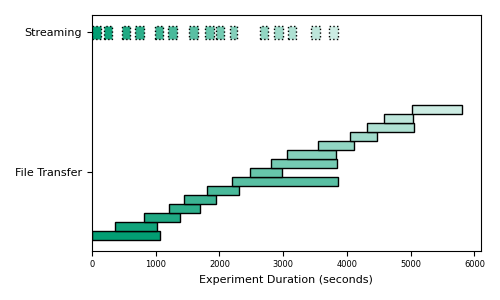

/tmp/ipykernel_1760239/1208620907.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_scans_sets = filtered_df.groupby('Description').apply(find_missing_scans)
/tmp/ipykernel_1760239/1208620907.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby('Description').apply(append_missing_scans).reset_index(drop=True)


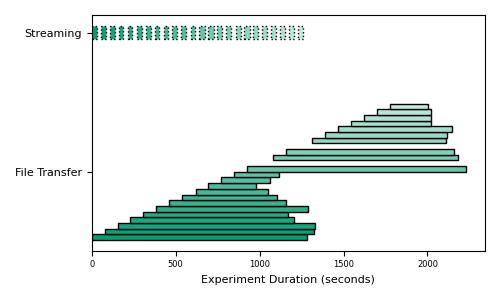

In [53]:
%matplotlib widget

import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import matplotlib.colors as mcolors
import seaborn as sns

# Function to plot the specified descriptions
def plot_descriptions(df, descriptions, plot_ranges, name, acq_to_color, colors_to_use):
    if len(acq_to_color) != len(colors_to_use):
        raise ValueError("The list of acquisitions to color and the list of colors must be the same length.")
    
    # Filter DataFrame for the specified descriptions
    filtered_df = df[df['Description'].isin(descriptions)].copy()

    # Apply plot_range filtering
    for desc, plot_range in plot_ranges.items():
        if desc in descriptions:
            filtered_df = filtered_df[(filtered_df['Description'] != desc) | 
                                      ((filtered_df['ScanNo'] >= plot_range[0]) & 
                                       (filtered_df['ScanNo'] <= plot_range[1]))]
            
    filtered_df['Normalized DM4 Time'] = filtered_df.groupby('Description')['DM4 DateTime'].transform(lambda x: (x - x.min()).dt.total_seconds())    
    
    # To get the missing scans
    def find_missing_scans(group):
        sorted_group = group.sort_values('ScanNo')
        expected_scans = range(sorted_group['ScanNo'].min(), sorted_group['ScanNo'].max() + 1)
        missing_scan_nos = set(expected_scans) - set(sorted_group['ScanNo'])
        return missing_scan_nos
        
    
    def append_missing_scans(group):
        missing_entries = []
        sorted_group = group.sort_values('ScanNo')
        expected_scans = range(sorted_group['ScanNo'].min(), sorted_group['ScanNo'].max() + 1)
        missing_scan_nos = set(expected_scans) - set(sorted_group['ScanNo'])
        
        for scan_no in missing_scan_nos:
            previous = sorted_group[sorted_group['ScanNo'] < scan_no].iloc[-1]
            next_scan = sorted_group[sorted_group['ScanNo'] > scan_no].iloc[0]
            avg_time = previous['Normalized DM4 Time'] + (next_scan['Normalized DM4 Time'] - previous['Normalized DM4 Time']) / 2
            fake_duration = (next_scan['Duration (s)'] + previous['Duration (s)']) / 2
            missing_entry = previous.copy()
            missing_entry['ScanNo'] = scan_no
            missing_entry['Normalized DM4 Time'] = avg_time
            missing_entry['Duration (s)'] = fake_duration
            missing_entries.append(missing_entry)

        # Ensure missing_entries is a DataFrame before concatenating
        if missing_entries:  # Check if there are any entries to add
            missing_df = pd.DataFrame(missing_entries)
            result_df = pd.concat([group, missing_df], ignore_index=True)
        else:
            result_df = group

        return result_df.sort_values('ScanNo')


    # Apply the function to each group
    missing_scans_sets = filtered_df.groupby('Description').apply(find_missing_scans)

    # Convert the pandas Series of sets to a single set (if you expect disjoint sets across groups)
    missing_scans = list(set().union(*missing_scans_sets))
    
    # Apply the function to append missing scans
    filtered_df = filtered_df.groupby('Description').apply(append_missing_scans).reset_index(drop=True)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(5, 3))
    
    y_positions_dict = {}
    current_y_position = 0.5
    
    for desc, group in filtered_df.groupby('Description'):
        group_size = len(group)
        bar_height = 0.1 if "Streaming" in desc else 1 / max(group_size, 1)
        y_positions = []

        start = group['Normalized DM4 Time']
        duration = group['Duration (s)']
        scan_no = group['ScanNo']
        
        for i, (s, w, no) in enumerate(zip(start, duration, scan_no)):
            y_position = current_y_position if "Streaming" in desc else current_y_position + i * bar_height
            y_positions.append(y_position)
            
            # Color and pattern settings
            if no in missing_scans:
                alpha = 0  # Semi-transparent
            elif i in acq_to_color:
                color = colors_to_use[acq_to_color.index(i)]  # Use specific color from the provided list
                alpha = 1
            else:
                color = 'lightgrey'  # Default color for other bars
                alpha = 1
            linestyle = ':' if 'Streaming' in desc else 'solid'

            
            ax.barh(y_position, w, left=s, color=color, edgecolor='black', alpha=alpha, height=bar_height, linestyle=linestyle)
        
        key = None
        if "Streaming" in desc:
            key = "Streaming"
        else:
            key = "File Transfer"
        y_positions_dict[key] = np.mean(y_positions)
        # y_positions_dict[desc] = np.mean(y_positions)
        current_y_position += 1 if "Streaming" in desc else group_size * bar_height + 0.5

    label_font_size = 8
    tick_font_size = 6
    ax.set_xlabel('Experiment Duration (seconds)', fontsize=label_font_size)
    ax.set_yticks(list(y_positions_dict.values()))
    ax.set_yticklabels(list(y_positions_dict.keys()))
    ax.tick_params(axis='x', labelsize=tick_font_size)
    ax.tick_params(axis='y', labelsize=label_font_size)
    plt.tight_layout()
    plt.show()
    fig.savefig(name, transparent=True, dpi=600)

# Load the data
df = pd.read_csv("matched_files.csv", parse_dates=["DM4 DateTime", "HDF5 DateTime"])
df['ScanNo'] = df['DM4 Path'].str.extract(r'scan(\d+)').astype(int)

# Load inputs.json
with open("inputs.json", "r") as file:
    datasets = json.load(file)

# Create a dictionary to store plot ranges for each description
plot_ranges = {
    dataset['description']: dataset.get('plot_range', dataset.get('scan_range'))
    for dataset in datasets
}


def interpolate_colors(color1, color2, num_colors):
    color1_rgb = np.array(mcolors.to_rgb(color1))
    color2_rgb = np.array(mcolors.to_rgb(color2))
    return [mcolors.to_hex(color) for color in np.linspace(color1_rgb, color2_rgb, num_colors)]


def lighten_color(color, amount=0.8):
    """
    Lightens the given color by mixing it with white.

    Parameters:
    - color (str or tuple): The color to lighten, either as a hex string or an RGB tuple.
    - amount (float): The amount to lighten the color, between 0 (no change) and 1 (white).

    Returns:
    - str: The lightened color as a hex string.
    """
    try:
        # Convert color to an RGB tuple
        c = mcolors.to_rgb(color)
    except ValueError:
        raise ValueError("Invalid color format. Use hex string (e.g., '#RRGGBB') or RGB tuple (e.g., (R, G, B)).")
    
    # Ensure amount is within the valid range
    if not 0 <= amount <= 1:
        raise ValueError("Amount should be between 0 and 1.")

    # Lighten the color by blending it with white
    white = np.array([1, 1, 1])
    lightened_color = c + (white - c) * amount

    # Convert the result back to a hex string
    return mcolors.to_hex(lightened_color)


palette = sns.color_palette("colorblind")


# Number of colors in the gradient
n_colors = 12

# Generate the gradient colors using interpolation
blue_gradient_figure_a = interpolate_colors(palette[0], lighten_color(palette[0]), n_colors)


n_colors = 12
orange_gradient_figure_a = interpolate_colors(palette[1], lighten_color(palette[1]), n_colors)

# Call the function for each set of descriptions

plot_descriptions(df, ["Ambarneil Streaming 1", "Ambarneil FT 3"], plot_ranges, "ambarneil.png", range(24), [blue_gradient_figure_a[x] for x in range(12)] + [orange_gradient_figure_a[x] for x in range(12)])


n_colors = 15
gradient_figure_b = interpolate_colors(palette[0], lighten_color(palette[0]), n_colors)
plot_descriptions(df, ["Aviram Streaming 1", "Aviram FT 4"], plot_ranges, "aviram.png", range(15), [gradient_figure_b[x] for x in range(15)])

n_colors = 15
gradient_figure_b = interpolate_colors(palette[2], lighten_color(palette[2]), n_colors)
plot_descriptions(df, ["Aviram Streaming 1", "Aviram FT 4"], plot_ranges, "aviram_streaming_only.png", range(15), [gradient_figure_b[x] for x in range(15)])

n_colors = 25
blue_gradient_figure_a_streaming = interpolate_colors(palette[2], lighten_color(palette[2]), n_colors)
plot_descriptions(df, ["Ambarneil Streaming 1", "Ambarneil FT 3"], plot_ranges, "ambarneil_streaming_only.png", range(24), [blue_gradient_figure_a_streaming[x] for x in range(24)])
